In [55]:
%pylab inline
from scipy.optimize import minimize
from scipy.integrate import simps
from scipy.special import spherical_jn
import os,sys
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


# Load quijote spectra (from Planck)

In [2]:
res = 1024.
L_box = 1000.

z=0.
all_Pk=[]
for sim in range(100):
    infile='/projects/QUIJOTE/Pk/matter/fiducial_HR/%d/Pk_m_z=%.0f.txt'%(sim,z)
    if not os.path.exists(infile):
        continue
    k,Pk = np.loadtxt(infile).T
    nbar = pow(res/L_box,3.)
    Pk-=1./nbar
    all_Pk.append(Pk)
all_Pk = np.asarray(all_Pk)
mean_Pk = all_Pk.mean(axis=0)
std_Pk = all_Pk.std(axis=0)
n_mocks = len(all_Pk)
k = np.asarray(k)
print('Using %d mocks'%n_mocks)

Using 100 mocks


In [3]:
filt = np.where(k<0.8)

In [132]:
sys.path.append('/home/ophilcox/EffectiveHalos/')
import EffectiveHalos as ph
reload(ph);

In [133]:
cosm = ph.Cosmology(z,name='Quijote')
mf = ph.MassFunction(cosm,'Bhattacharya')

In [134]:
hp = ph.HaloPhysics(cosm,mf,npoints=300);

kh_min = np.pi*2./L_box

halop = ph.HaloModel(cosm,mf,hp,k,kh_min)

### Define models

In [135]:
def fid_model(pars):
    return halop.halo_model(pars[0],pars[1],'EFT',1,1,1)
def lin_model(pars):
    return halop.halo_model(pars[0],pars[1],'Linear',0,0,0)

##### Define model where halo smoothing is a function of mass

In [210]:
mi = halop.mass_integrals

dn_dm = mi._compute_mass_function()
b_m = mi._compute_linear_bias()
m_u_m = mi._compute_fourier_profile()
m_u_m_0 = hp.halo_profile(mi.m_h_grid,-1,True)

I_11s_0 = simps(dn_dm*b_m*m_u_m_0,mi.logM_h_grid)
A = 1. - I_11s_0

def compute_I_fn(f_Lag):
    RR = np.power(3.*mi.m_h_grid/(4.*np.pi*cosm.rhoM),1./3.)*f_Lag
    kR = k.reshape(-1,1)*RR.reshape(1,-1)
    smoothing = 3.*(np.sin(kR)-kR*np.cos(kR))/kR**3.

    I_11s = simps(dn_dm*b_m*m_u_m*smoothing,mi.logM_h_grid,axis=1)
   
    ## Now do compensation
    I_11s = I_11s + A*m_u_m[:,0]*smoothing[:,0]/(m_u_m_0[0]*smoothing[0,0])
    return I_11s

def mass_dep_smooth_model(pars):
    p_NL = halop.non_linear_power(pars[0],pars[1],'EFT',1,0,1)
    return compute_I_fn(pars[1]*0.3)**2.*p_NL + halop.I_20

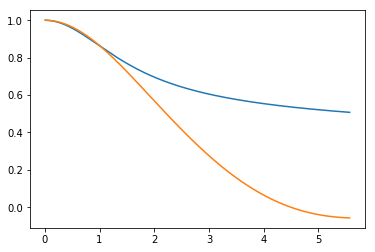

In [219]:
halop.halo_model(1,1);

plt.plot(k,compute_I_fn(0.2))
plt.plot(k,halop.I_11*halop._compute_smoothing_function(1.))

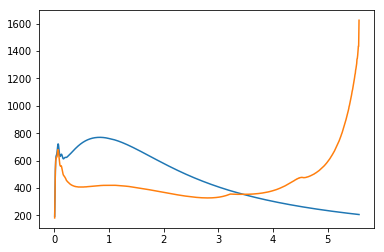

In [212]:
plt.plot(k,mass_dep_smooth_model([0,0.4])*k)
plt.plot(k,nbody_mean*k)

In [213]:
model = {'Linear':lin_model,'Fiducial':fid_model,'W(k,R_m)':mass_dep_smooth_model}
names = model.keys()

#### Fit models and plot

In [214]:
cols = ['blue','red','green']#purple','orange','cyan','green']
k_fit = 0.8
n_fit = np.where(k<k_fit)[0][-1]

print('Fitting up to %.2f'%k[n_fit])

nbody_mean = all_Pk.mean(axis=0)
nbody_std = all_Pk.std(axis=0)/np.sqrt(len(all_Pk))

# Define covariance parameters
dk = np.mean(np.diff(k))
survey_vol = L_box**3.
N_modes = k**2.*dk*survey_vol/(2.*np.pi**2.)

def fit_model(model):
    def chi2(par):
        pred = model(par)[:n_fit]
        cov_Pk_diag = pred**2.*2./N_modes[:n_fit]
        prec_diag = 1./cov_Pk_diag
        prec = np.diag(prec_diag)
        diff = pred - nbody_mean[:n_fit]
        chi2val = np.matmul(diff.T,np.matmul(prec,diff))
        return chi2val
    x = minimize(chi2,[1.,1.])
    return x.x

fit_pars = []
for n,name in enumerate(names):
    fit_par = fit_model(model[name])
    fit_pars.append(fit_par)

Fitting up to 0.79


('Model: "W(k,R_m)", parameters: ', array([1., 1.]))
('Model: "Linear", parameters: ', array([1., 1.]))
('Model: "Fiducial", parameters: ', array([9.26330539, 1.71138959]))


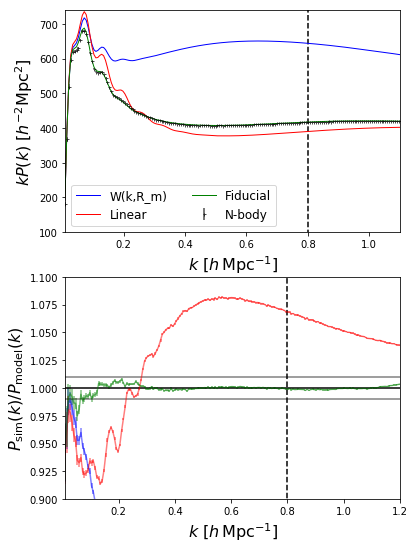

In [215]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
for n,name in enumerate(names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    alp = 1.
    lw = 1
    ax[0].plot(k,k*pred,label=name,alpha=alp,c=cols[n],lw=lw)
ax[0].legend(fontsize=12,ncol=2)
ax[0].set_ylim([100.,740])
ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,1.1]);

for n,name in enumerate(names):
    fit_par = fit_pars[n]
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.5
    else:
        alp=1.
    ax[1].errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label=name,alpha=alp,c=cols[n])
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[1].hlines(1.,0.001,10.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,10.,color='k',alpha=0.5)
ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.9,1.1])
ax[1].set_xlim([0.01,1.2]);

##### Note:

It is hard to get good results using this smoothing. This is because we don't get the total 2-halo power smoothed to zero at moderate $k$, since the smoothing term tends to zero *very* slowly for the smallest masses.

#### Try out Valageas 1-halo model

In [146]:
from scipy.integrate import simps
mass_integ = halop.mass_integrals
n_m = mass_integ._compute_mass_function()
m_u_m = mass_integ._compute_fourier_profile()
m_norm = hp.halo_profile(mass_integ.m_h_grid,k,1)

In [147]:
def th_ex(k,m):
    RL = np.power(3.*m/(4.*np.pi*cosm.rhoM),1./3.) # lagrangian radius
    kR = k.reshape(-1,1)*RL.reshape(1,-1)
    Wk = 3.*(np.sin(kR)-kR*np.cos(kR))/(kR**3.)
    return Wk

In [148]:
WkR = th_ex(k,mass_integ.m_h_grid)*m_norm;

In [149]:
i20 = simps(m_u_m**2.*n_m,mass_integ.logM_h_grid)
i20_ex = simps(n_m*(m_u_m-WkR)**2.,mass_integ.logM_h_grid)

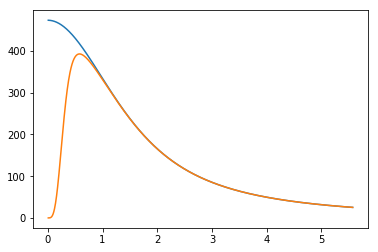

In [150]:
plt.plot(k,i20)
plt.plot(k,i20_ex)

### Try out Baldauf 2-halo model

In [186]:
from scipy.integrate import simps
mass_integ = halop.mass_integrals
n_m = mass_integ._compute_mass_function()
m_u_m = mass_integ._compute_fourier_profile()
b_m = mass_integ._compute_linear_bias()

In [202]:
n1 = n_m.reshape(1,-1,1)
n2 = n_m.reshape(1,1,-1)
b1 = b_m.reshape(1,-1,1)
b2 = b_m.reshape(1,1,-1)
mum1 = m_u_m[:,:,np.newaxis]
mum2 = m_u_m[:,np.newaxis,:]

def mass_to_Lag(m,odelta=200):
    return np.power(3.*m/(4.*odelta*np.pi*cosm.rhoM),1./3.)
R_ex = mass_to_Lag(mass_integ.m_h_grid.reshape(-1,1)+mass_integ.m_h_grid.reshape(1,-1))
V_ex = (4.*np.pi*R_ex**3./3.)[np.newaxis,:,:]

In [203]:
P2h_ex = - simps(simps(n1*n2*mum1*mum2*V_ex,mass_integ.logM_h_grid,axis=1),mass_integ.logM_h_grid,axis=1)

In [204]:
from mcfit import P2xi, xi2P
from scipy.interpolate import interp1d, interp2d

In [205]:
# Define a power spectrum
kk = np.logspace(-4,1,10000)
pp = cosm.compute_linear_power(kk)

# Transform to real space for convolution
r,xi = P2xi(kk,lowring=False)(pp)

# Define interpolation grid
RR = np.linspace(0,max(R_ex.ravel())+10,1000)

# Multiply in real-space and transform
xi = np.vstack([xi for _ in range(len(RR))])
xi[r.reshape(1,-1)>RR.reshape(-1,1)]=0.

# Interpolate into one dimension and return
kk,pp = xi2P(r,lowring=False)(xi)
int2d = interp2d(kk,RR,pp)
int1d = interp1d(RR,int2d(k,RR).T)
P_V_int = int1d


In [206]:
p_v_conv = P_V_int(R_ex)

In [207]:
P2h_ex2 = - simps(simps(n1*n2*mum1*mum2*p_v_conv,mass_integ.logM_h_grid*b1*b2,axis=1),mass_integ.logM_h_grid,axis=1)

In [208]:
_=halop.halo_model(1,1)

In [209]:
P2L = halop.I_11**2.*cosm.compute_linear_power(k)
P1h = halop.I_20

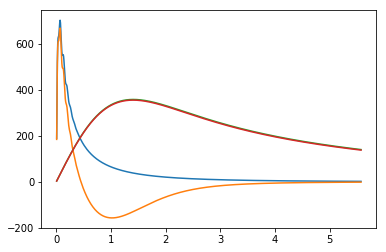

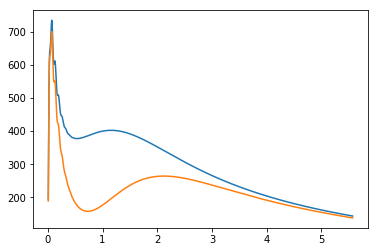

In [215]:
#plt.plot(k,(P2h_ex*0+P2h_ex2)*k)
plt.plot(k,P2L*k)
plt.plot(k,k*(P2L+P2h_ex2));
plt.plot(k,k*P1h)
plt.plot(k,k*(P1h+P2h_ex));
plt.figure()
plt.plot(k,k*(P2L+P1h))
plt.plot(k,k*(P2L+P2h_ex2+P2h_ex+P1h))

In [252]:
def zelNoCt(pars):
    return halop.I_11**2.*zP  + halop.I_20
def zelLinCt(pars):
    return halop.I_11**2.*(zP - pars[0]*k**2./(1.+k**2.)*lP)*halop._compute_smoothing_function(pars[1])**2. + halop.I_20
    #return zP + (1. - 1./(1.+k**2*26**2.))*1./(1.+k**2.*pars[0]**2.)

def zelZelCt(pars):
    return halop.I_11**2.*(zP - pars[0]*k**2./(1.+0*k**2.)*zP)*halop._compute_smoothing_function(pars[1])**2. + halop.I_20

def compHalo(pars):
    return halop.halo_model(pars[0],pars[1],'EFT',1,1,1) - halop.I_20 + i20_ex
def twoHalo(pars):
    return halop.halo_model(pars[0],pars[1],'EFT',1,0,1) - halop.I_20

def GaussSmooth(pars):
    return (halop.halo_model(pars[0],pars[1],'EFT',1,0,1)-halop.I_20)*np.exp(-k**2.*pars[1]**2.)+halop.I_20

In [253]:
# names = ['Full Model','Linear','Zel`dovich','Zel`dovich + Counterterm','CompHalo','TwoHalo','GaussSmooth']
# model = {'Full Model':P1,'Linear':P6,'Zel`dovich':zelNoCt,'Zel`dovich + Counterterm':zelLinCt,'CompHalo':compHalo,
#         'TwoHalo':twoHalo,'GaussSmooth':GaussSmooth}

In [257]:
names = ['Linear','Full Model','Gaussian Smoothing']
model = {'Linear':P6,'Full Model':P1,'Gaussian Smoothing':GaussSmooth}

In [260]:
cols = ['blue','red','green']#purple','orange','cyan','green']
k_fit = 0.8
n_fit = np.where(k<k_fit)[0][-1]

print('Fitting up to %.2f'%k[n_fit])

nbody_mean = all_Pk.mean(axis=0)
nbody_std = all_Pk.std(axis=0)/np.sqrt(len(all_Pk))

# Define covariance parameters
dk = np.mean(np.diff(k))
survey_vol = L_box**3.
N_modes = k**2.*dk*survey_vol/(2.*np.pi**2.)

def fit_model(model):
    def chi2(par):
        pred = model(par)[:n_fit]
        cov_Pk_diag = pred**2.*2./N_modes[:n_fit]
        prec_diag = 1./cov_Pk_diag
        prec = np.diag(prec_diag)
        diff = pred - nbody_mean[:n_fit]
        chi2val = np.matmul(diff.T,np.matmul(prec,diff))
        return chi2val
    x = minimize(chi2,[1.,1.])
    return x.x

fit_pars = []
for n,name in enumerate(names):
    fit_par = fit_model(model[name])
    fit_pars.append(fit_par)

Fitting up to 0.79


('Model: "Linear", parameters: ', array([1., 1.]))
('Model: "Full Model", parameters: ', array([9.26330539, 1.71138959]))
('Model: "Gaussian Smoothing", parameters: ', array([9.23145391, 0.78168098]))


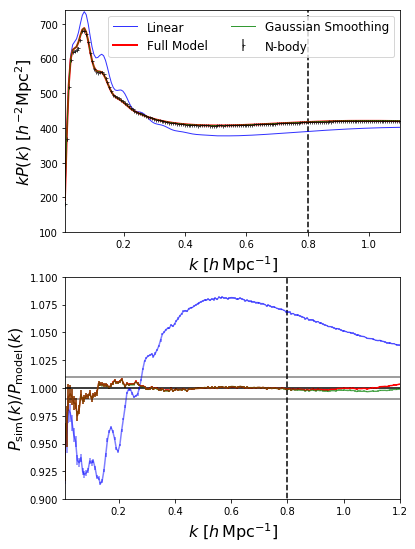

In [263]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
for n,name in enumerate(names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.8
        lw=1
    else:
        alp=1.
        lw=2
    ax[0].plot(k,k*pred,label=name,alpha=alp,c=cols[n],lw=lw)
#plt.plot(k,k*(p2halo+p1halo),label='HM')
#plt.plot(k,k*p1halo,label='1-halo term')
#plt.xscale('log')
ax[0].legend(fontsize=12,ncol=2)
#plt.gca().legend(bbox_to_anchor=(1.,0.6),fontsize=14,ncol=2);
ax[0].set_ylim([100.,740])
ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,1.1]);

for n,name in enumerate(names):
    fit_par = fit_pars[n]
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.5
    else:
        alp=1.
    ax[1].errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label=name,alpha=alp,c=cols[n])
#plt.errorbar(k,nbody_mean/(p2halo+p1halo),yerr=nbody_std/(p2halo+p1halo),label='HM')
#ax[1].set_xscale('log')
#plt.legend()
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
#plt.gca().legend(bbox_to_anchor=(1.,0.5),fontsize=14);
ax[1].hlines(1.,0.001,10.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,10.,color='k',alpha=0.5)
ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.9,1.1])
ax[1].set_xlim([0.01,1.2]);
#fig.savefig('Quijote_comparison_Pk.pdf',bbox_inches='tight')

In [144]:
zelNo = zelNoCt(fit_model(zelNoCt))
zelLin = zelLinCt(fit_model(zelLinCt))
zelZel = zelZelCt(fit_model(zelZelCt))
#zel

In [146]:
fit_model(zelLinCt)

array([-3.432224  ,  1.54282851])

('Model: "Full Model", parameters: ', array([9.26328748, 1.71139476]))


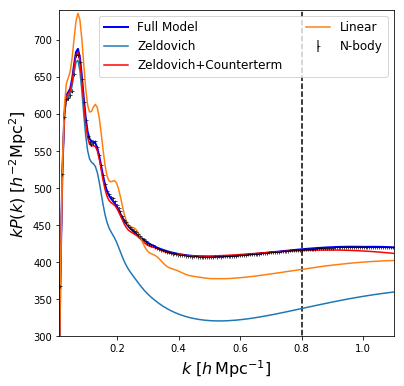

In [138]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
cut_names = ['Full Model']#, 'Vanilla']
for n,name in enumerate(cut_names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.8
        lw=1
    else:
        alp=1.
        lw=2
    ax.plot(k,k*pred,label=name,alpha=alp,c=cols[n],lw=lw)
ax.plot(k,k*zelMod,label='Zeldovich')
ax.plot(k,k*zelCtMod(zelPar),label='Zeldovich+Counterterm',c='r')
ax.plot(k,k*linMod,label='Linear')
#plt.plot(k,k*p1halo,label='1-halo term')
#plt.xscale('log')
ax.legend(fontsize=12,ncol=2)
#plt.gca().legend(bbox_to_anchor=(1.,0.6),fontsize=14,ncol=2);
ax.set_ylim([300.,740])
ax.vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax.set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
ax.set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax.set_xlim([0.01,1.1]);

(0.95, 1.05)

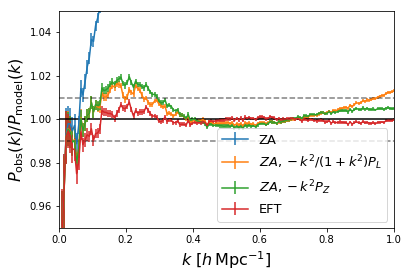

In [139]:
plt.errorbar(k,nbody_mean/zelNo,yerr=nbody_std/zelNo,label='ZA')
plt.errorbar(k,nbody_mean/zelLin,yerr=nbody_std/zelLin,label=r'$ZA, -k^2/(1+k^2)P_L$')
plt.errorbar(k,nbody_mean/zelZel,yerr=nbody_std/zelZel,label=r'$ZA, -k^2P_Z$')
plt.errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label='EFT')
plt.xlim([0.,1.])
plt.ylabel(r'$P_\mathrm{obs}(k)/P_\mathrm{model}(k)$',fontsize=16)
plt.xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
plt.legend(fontsize=13)
plt.hlines([0.99,1.01],0,1,linestyles='--',alpha=0.5)
plt.hlines(1,0,1)
plt.ylim([0.95,1.05])

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
for n,name in enumerate(names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.8
        lw=1
    else:
        alp=1.
        lw=2
    ax[0].plot(k,k*pred,label=name,alpha=alp,c=cols[n],lw=lw)
#plt.plot(k,k*(p2halo+p1halo),label='HM')
#plt.plot(k,k*p1halo,label='1-halo term')
#plt.xscale('log')
ax[0].legend(fontsize=12,ncol=2)
#plt.gca().legend(bbox_to_anchor=(1.,0.6),fontsize=14,ncol=2);
ax[0].set_ylim([300.,740])
ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,1.1]);

for n,name in enumerate(names):
    fit_par = fit_pars[n]
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.5
    else:
        alp=1.
    ax[1].errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label=name,alpha=alp,c=cols[n])
#plt.errorbar(k,nbody_mean/(p2halo+p1halo),yerr=nbody_std/(p2halo+p1halo),label='HM')
ax[1].set_xscale('log')
#plt.legend()
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
#plt.gca().legend(bbox_to_anchor=(1.,0.5),fontsize=14);
ax[1].hlines(1.,0.001,10.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,10.,color='k',alpha=0.5)
ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.9,1.1])
ax[1].set_xlim([0.01,2.]);
#fig.savefig('Quijote_comparison_Pk.pdf',bbox_inches='tight')

('Model: "Full Model", parameters: ', array([ 9.26324138,  1.71141581]))
('Model: "No IR", parameters: ', array([ 9.24038268,  1.70087261]))
('Model: "No Truncation", parameters: ', array([ 10.44060487,   1.        ]))
('Model: "No Counterterm", parameters: ', array([ 1.        ,  3.68228258]))
('Model: "No Pade", parameters: ', array([ 6.53245888,  1.7000137 ]))
('Model: "Vanilla", parameters: ', array([ 1.,  1.]))


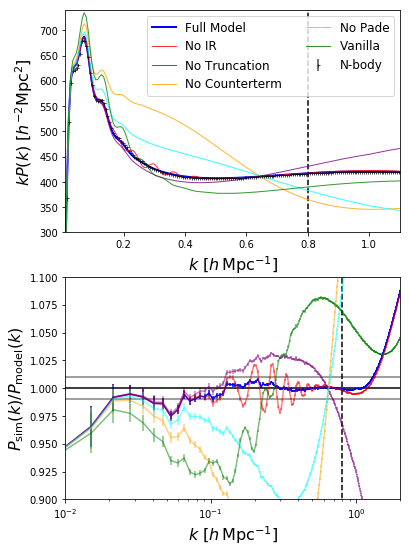

In [42]:
fig,ax = plt.subplots(2,1,figsize=(6,9))
ax[0].errorbar(k,k*nbody_mean,yerr=k*nbody_std,label='N-body',ls='',marker='+',ms=3,c='k',alpha=0.7)
for n,name in enumerate(names):
    fit_par = fit_pars[n]
    print('Model: "%s", parameters: '%name,fit_par)
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.8
        lw=1
    else:
        alp=1.
        lw=2
    ax[0].plot(k,k*pred,label=name,alpha=alp,c=cols[n],lw=lw)
#plt.plot(k,k*(p2halo+p1halo),label='HM')
#plt.plot(k,k*p1halo,label='1-halo term')
#plt.xscale('log')
ax[0].legend(fontsize=12,ncol=2)
#plt.gca().legend(bbox_to_anchor=(1.,0.6),fontsize=14,ncol=2);
ax[0].set_ylim([300.,740])
ax[0].vlines(k_fit,0,1000,color='k',alpha=1.,linestyles='--')
ax[0].set_ylabel(r'$kP(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]',fontsize=16)
ax[0].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
ax[0].set_xlim([0.01,1.1]);

for n,name in enumerate(names):
    fit_par = fit_pars[n]
    pred = model[name](fit_par)
    if name!='Full Model':
        alp=0.5
    else:
        alp=1.
    ax[1].errorbar(k,nbody_mean/pred,yerr=nbody_std/pred,label=name,alpha=alp,c=cols[n])
#plt.errorbar(k,nbody_mean/(p2halo+p1halo),yerr=nbody_std/(p2halo+p1halo),label='HM')
ax[1].set_xscale('log')
#plt.legend()
ax[1].set_ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{model}(k)$',fontsize=16)
ax[1].set_xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=16)
#plt.gca().legend(bbox_to_anchor=(1.,0.5),fontsize=14);
ax[1].hlines(1.,0.001,10.,color='k',alpha=1)
ax[1].hlines([0.99,1.01],0.001,10.,color='k',alpha=0.5)
ax[1].vlines(k_fit,0,2,color='k',alpha=1.,linestyles='--')
ax[1].set_ylim([0.9,1.1])
ax[1].set_xlim([0.01,2.]);
#fig.savefig('Quijote_comparison_Pk.pdf',bbox_inches='tight')

### Fits sims separately

In [84]:
cols = ['blue','red','purple','orange','cyan','green']
k_fit = 0.8
n_fit = np.where(k<k_fit)[0][-1]

print('Fitting up to %.2f'%k[n_fit])

nbody_mean = all_Pk.mean(axis=0)
nbody_std = all_Pk.std(axis=0)/np.sqrt(len(all_Pk))

# Define covariance parameters
dk = np.mean(np.diff(k))
survey_vol = L_box**3.
N_modes = k**2.*dk*survey_vol/(2.*np.pi**2.)

opt_par_all = fit_model(model[names[0]])

all_par = []
all_model = []
all_fix_model = []
for i in range(100):
    this_sim = all_Pk[i]
    def fit_single_model(model):
        def chi2(par):
            pred = model(par)[:n_fit]
            cov_Pk_diag = pred**2.*2./N_modes[:n_fit]
            prec_diag = 1./cov_Pk_diag
            prec = np.diag(prec_diag)
            diff = pred - this_sim[:n_fit]
            chi2val = np.matmul(diff.T,np.matmul(prec,diff))
            return chi2val
        x = minimize(chi2,[1.,1.])
        return x.x
    fit_par = fit_single_model(model[names[0]])
    all_model.append(model[names[0]](fit_par))
    all_fix_model.append(model[names[0]](opt_par_all))
    all_par.append(np.asarray(fit_par))

Fitting up to 0.79


In [ ]:
for i in range(100):
    plt.plot(k,all_Pk[i]/all_model[i],c='b',alpha=0.01)
rat = all_Pk/np.asarray(all_model)
plt.errorbar(k,rat.mean(axis=0),yerr=rat.std(axis=0)/np.sqrt(len(rat)),c='r')
plt.xlim([min(k),1.])
plt.vlines(k_fit,0.9,1.5,linestyles='--')
plt.hlines(1.01,0,1,alpha=0.5)
plt.hlines(0.99,0,1,alpha=0.5)
plt.ylim([0.95,1.05])
plt.ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{HM}(k)$',fontsize=15)
plt.xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=15);
plt.savefig('Quijote_100_separate_fits.pdf',bbox_inches='tight')

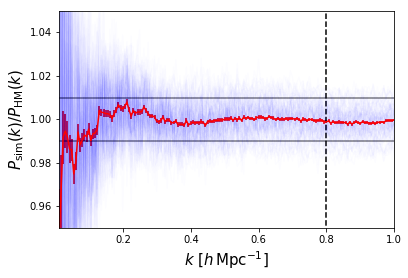

In [102]:
for i in range(100):
    plt.plot(k,all_Pk[i]/all_fix_model[i],c='b',alpha=0.01)
rat = all_Pk/np.asarray(all_fix_model)
plt.errorbar(k,rat.mean(axis=0),yerr=rat.std(axis=0)/np.sqrt(len(rat)),c='r')
plt.xlim([min(k),1.])
plt.vlines(k_fit,0.9,1.5,linestyles='--')
plt.hlines(1.01,0,1,alpha=0.5)
plt.hlines(0.99,0,1,alpha=0.5)
plt.ylim([0.95,1.05])
plt.ylabel(r'$P_\mathrm{sim}(k)/P_\mathrm{HM}(k)$',fontsize=15)
plt.xlabel(r'$k$ $[h\,\mathrm{Mpc}^{-1}]$',fontsize=15);
plt.savefig('Quijote_100_combined_fits.pdf',bbox_inches='tight')

In [58]:
all_par = np.asarray(all_par)

print(all_par.mean(axis=0))
print(all_par.std(axis=0))

[2.36436653 1.26986467]
[0.04498555 0.02122323]


In [59]:
np.corrcoef(all_par.T)

array([[ 1.        , -0.77617915],
       [-0.77617915,  1.        ]])

# SCRATCH BELOW HERE!

In [35]:
m_h = np.logspace(13,15,100)
m_phys = m_h/cosm.h
R_lag = np.power(3.*m_phys/(200.*cosm.rhoM)/(4.*np.pi),1./3.)*cosm.h

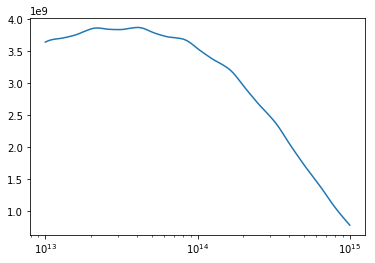

In [36]:
plt.semilogx(m_h,m_h*mf.mass_function(m_h))

### Load halo catalogs

In [24]:
import sys
import readfof
sys.path.append('/home/ophilcox/HaloPower/Pylians/library/build/lib.linux-x86_64-2.7/')

halo_snapnum = 4

# determine the redshift of the catalogue
z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0}
halo_redshift = z_dict[halo_snapnum]

assert(redshift==halo_redshift)
all_masses = []
n_halos = []

for n_sim in range(100):

    # input files
    halo_snapdir = '/projects/QUIJOTE/Halos/fiducial_HR/%d/'%n_sim #folder hosting the catalogue

    # read the halo catalogue
    FoF = readfof.FoF_catalog(halo_snapdir, halo_snapnum, long_ids=False,
                              swap=False, SFR=False, read_IDs=False)

    # get the properties of the halos
    #pos_h1 = FoF.GroupPos/1e3            #Halo positions in Mpc/h                                                                                                                                                                       
    mass1  = FoF.GroupMass*1e10          #Halo masses in Msun/h                                                                                                                                                                      
    all_masses.append(mass1)
    n_halos.append(len(mass1))
    
all_masses = np.asarray(all_masses)
n_halos = np.asarray(n_halos)
assert(len(n_halos==100))

In [25]:
np.savez('quijote_mass.npz',n_halos=n_halos,all_masses=all_masses)

### Compute some mass spectra at low N-grid

In [396]:
m_res = np.max([np.min(mm) for mm in all_masses])
print('Mass resolution: %.2e'%m_res)
mass_cuts = 10.**np.arange(12.3,13.7,0.2)
assert(min(mass_cuts)>m_res)
halos_above_M = np.asarray([[len(mm[mm>mass_cut]) for mm in all_masses] for mass_cut in mass_cuts]).T

Mass resolution: 1.64e+12


### Look at halo count covariance

In [429]:
m_res = np.max([np.min(mm) for mm in all_masses])
print('Mass resolution: %.2e'%m_res)
mass_bins = 10.**np.arange(12.3,14.,0.2)
mass_low = mass_bins[:-1]
mass_high = mass_bins[1:]
assert(min(mass_bins)>m_res)
halos_in_bin = np.asarray([[len(mm[np.logical_and(mm>=mass_low[i],mm<mass_high[i])]) for mm in all_masses] for i in range(len(mass_low))]).T

Mass resolution: 1.64e+12


### Compute ST n(M) and biases n(M)b(M) in bin

In [430]:
n_bins = len(mass_low)
n_ST = np.zeros(n_bins)
n_bias_ST = np.zeros(n_bins)
av_mass = 0.5*(np.asarray(mass_low)+np.asarray(mass_high))
for i in range(n_bins):
    mini_grid = np.linspace(np.log10(mass_low[i]),np.log10(mass_high[i]),1000)
    mini_dn_dlogM = mass_function_ST(10.**mini_grid,cosmol,z=z)/h**3.
    odelta = Dv_BryanNorman(z) # for virial definitions
    mini_bias = linear_halo_bias(10.**mini_grid,odelta,z=z)
    n_ST[i] = simps(mini_dn_dlogM,mini_grid)
    n_bias_ST[i] = simps(mini_dn_dlogM*mini_bias,mini_grid)

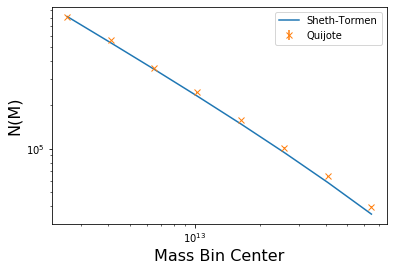

In [431]:
plt.plot(av_mass,n_ST*1e9,label='Sheth-Tormen')
plt.errorbar(av_mass,halos_in_bin.mean(axis=0),yerr=halos_in_bin.std(axis=0),marker='x',ls='',label='Quijote')
plt.legend();
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N(M)',fontsize=16)
plt.xlabel('Mass Bin Center',fontsize=16);

### Compute estimate of $\sigma^2(V_s)$

In [432]:
survey_vol = 1000**3.
survey_R = 1000.#(3.*survey_vol/(4.*np.pi))**(1./3.)
sigma2_Vs = ccl.sigmaR(cosmol,survey_R/h)**2.

## NB: $\sigma^2(V_s)$ has $\mathcal{O}(1)$ uncertainty

In [433]:
cov_counts = np.cov(halos_in_bin.T)
n_bins = len(cov_counts)
def cov_model(bin_1,bin_2):
    out = survey_vol**2*n_bias_ST[bin_1]*n_bias_ST[bin_2]*sigma2_Vs/3
    out+=(bin_1==bin_2)*n_bias_ST[bin_1]*survey_vol
    return out

In [434]:
model_cov = np.zeros_like(cov_counts)
c=['r','b','g','k','purple']
for i in range(n_bins):
    for j in range(n_bins):
        model_cov[i,j]=cov_model(i,j)

### extra / 2 to make things work

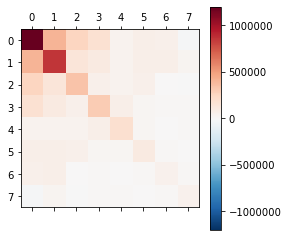

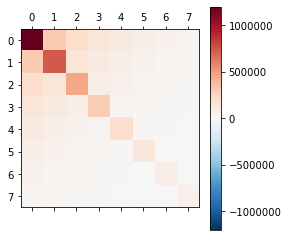

In [435]:
vmax = np.max(cov_counts)
plt.matshow(cov_counts,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax);plt.colorbar();
plt.matshow(model_cov,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);plt.colorbar();

## Define covariance between $N(m\in [M_0,M_1])$ and $P(k)$

In [436]:
n_sims = len(halos_in_bin)

diff_N = halos_in_bin - halos_in_bin.mean(axis=0)
diff_Pk = all_Pk - all_Pk.mean(axis=0)

cov_Nm_Pk = np.zeros([len(diff_N[0]),len(diff_Pk[0])])
err_cov = np.zeros_like(cov_Nm_Pk)

cov_Nm_Pk = np.matmul(diff_N.T,diff_Pk)
cov_Nm_Pk/=(n_sims-1)

all_cov_est = []
for n in range(n_sims):
    this_cov = np.zeros_like(cov_Nm_Pk)
    one_less_N = np.concatenate([diff_N[:n],diff_N[n+1:]])
    one_less_Pk = np.concatenate([diff_Pk[:n],diff_Pk[n+1:]])
    this_cov = np.matmul(one_less_N.T,one_less_Pk)
    this_cov/=(n_sims-2)
    all_cov_est.append(this_cov)
all_cov_est = np.asarray(all_cov_est)
jackknife_cov_err = np.sqrt(((all_cov_est-all_cov_est.mean(axis=0))**2).sum(axis=0)/(n_sims-1))

In [437]:
comb_Pk = np.zeros((len(all_Pk),len(all_Pk[0])//4))
comb_k = np.zeros(len(all_Pk[0])//4)
for i in range(len(all_Pk[0])):
    try:
        comb_Pk[:,i//4]+=all_Pk[:,i]*k[i]
        comb_k[i//4]+=k[i]
    except IndexError:
        break
comb_k/=4.
comb_Pk/=(4.*comb_k)

diff_comb_Pk = comb_Pk - comb_Pk.mean(axis=0)

comb_cov_Nm_Pk = np.zeros([len(diff_N[0]),len(diff_comb_Pk[0])])

comb_cov_Nm_Pk = np.matmul(diff_N.T,diff_comb_Pk)
comb_cov_Nm_Pk/=(n_sims-1)

all_comb_cov_est = []
for n in range(n_sims):
    this_comb_cov = np.zeros_like(cov_Nm_Pk)
    one_less_N = np.concatenate([diff_N[:n],diff_N[n+1:]])
    one_less_comb_Pk = np.concatenate([diff_comb_Pk[:n],diff_comb_Pk[n+1:]])
    this_comb_cov = np.matmul(one_less_N.T,one_less_comb_Pk)
    this_comb_cov/=(n_sims-2)
    all_comb_cov_est.append(this_comb_cov)
all_comb_cov_est = np.asarray(all_comb_cov_est)
jackknife_comb_cov_err = np.sqrt(((all_comb_cov_est-all_comb_cov_est.mean(axis=0))**2).sum(axis=0)/(n_sims-1))

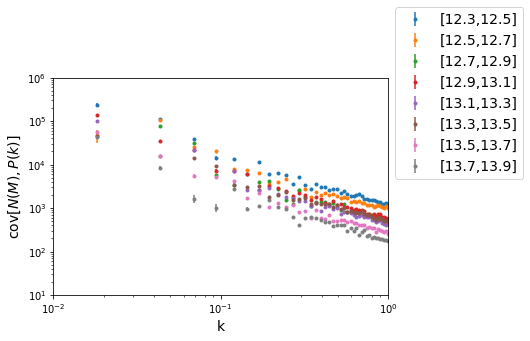

In [438]:
for i in range(n_bins):
    plt.errorbar(comb_k,-comb_cov_Nm_Pk[i],yerr=jackknife_comb_cov_err[i],
                 label=r'[%.1f,%.1f]'%(np.log10(mass_low[i]),np.log10(mass_high[i])),ls='',marker='.')
plt.legend();
plt.ylabel(r'$\mathrm{cov}\left[N(M),P(k)\right]$',fontsize=14)
plt.xlabel('k',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-2,1]);
plt.ylim([10,1e6]);
plt.gca().legend(bbox_to_anchor=(1.,0.5),fontsize=14);

## NB: extra -1 here?

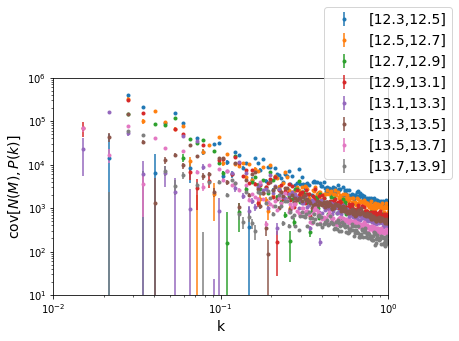

In [442]:
for i in range(n_bins):
    plt.errorbar(k,-cov_Nm_Pk[i],yerr=jackknife_cov_err[i],
                 label=r'[%.1f,%.1f]'%(np.log10(mass_low[i]),np.log10(mass_high[i])),ls='',marker='.')
plt.legend();
plt.ylabel(r'$\mathrm{cov}\left[N(M),P(k)\right]$',fontsize=14)
plt.xlabel('k',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-2,1]);
plt.ylim([10,1e6]);
plt.gca().legend(bbox_to_anchor=(1.,0.5),fontsize=14);

### Compute model covariances

In [469]:
class N_P_cov:
    ## Class to hold N(M), P(k) model
    
    def __init__(self,mass_min,mass_max,kh):
        self.mass_min = mass_min # in Msun/h units
        self.mass_max = mass_max
        assert self.mass_max<1e17, 'Max mass must be less than 10^17 Msun/h for CCL'
        self.kh = kh # in h/Mpc units
        self.nk = len(kh)
        
        # Compute useful quantities
        self.rho_matter = ccl.rho_x(cosmol,1.,'matter',True) # matter density
        self.odelta = Dv_BryanNorman(z) # for virial definitions
        
        # Compute arrays of quantities in this mass range
        self.logM_grid = np.linspace(np.log10(self.mass_min),np.log10(self.mass_max),1000)
        self.M_grid = 10.**self.logM_grid # Msun/h units
        self.conc_grid = halo_conc(self.M_grid,z=redshift,odelta=self.odelta)
        self.dn_dlogM_grid = np.asarray([mass_function_ST(MM,cosmol,z=z) for MM in self.M_grid])
        self.uM_rho_grid = np.asarray([window_function(self.M_grid,kk*h,z=z,odelta=self.odelta) for kk in self.kh])
        self.linear_halo_bias_grid = linear_halo_bias(self.M_grid,self.odelta,z=z)
        
        # compute mean number density
        self.nbar = simps(self.dn_dlogM_grid,self.logM_grid)
        
    def compute_two_halo_prefactor(self): 
        # Compute 2-halo prefactor
        if not hasattr(self,'two_halo_prefactor'):
        
            pref_2_halo = np.asarray([simps(two_halo_integrand(kh,logm_grid,z=redshift),logm_grid) for kh in self.kh])

            min_window = np.asarray([window_function(10.**np.min(logm_grid)*h,kk*h,z=redshift,odelta=1.) for kk in self.kh])
            zero_window = window_function(10.**np.min(logm_grid)*h,0.,z=redshift,odelta=1.)
            full_pref_2_halo = pref_2_halo + A*min_window/zero_window
            self.two_halo_prefactor = full_pref_2_halo
        return self.two_halo_prefactor
    
    def compute_modified_two_halo_prefactor(self): 
        # Compute 2-halo prefactor
        if not hasattr(self,'modified_two_halo_prefactor'):
        
            def modified_two_halo_integrand(kh,log10mass,z=redshift):
                # extra factor of linear bias here
                m = 10.**log10mass # in Msun
                m_h = m*h # in Msun/h
                k = kh*h # remove h dependence
                odelta = Dv_BryanNorman(z=redshift) # for virial definitions
                wk = window_function(m_h,k,z,odelta)
                dn_dlogM = mass_function_ST(m_h,cosmol,z=z)
                b = linear_halo_bias(m_h,odelta,z=z)
                return dn_dlogM*wk*b**2.
        
            pref_2_halo_mod = np.asarray([simps(modified_two_halo_integrand(kh,logm_grid,z=redshift),logm_grid) for kh in self.kh])
            min_window = np.asarray([window_function(10.**np.min(logm_grid)*h,kk*h,z=redshift,odelta=1.) for kk in self.kh])
            zero_window = window_function(10.**np.min(logm_grid)*h,0.,z=redshift,odelta=1.)
            full_mod_pref_2_halo = pref_2_halo_mod + A*min_window/zero_window
            self.modified_two_halo_prefactor = full_mod_pref_2_halo
        return self.modified_two_halo_prefactor
    
    def compute_modified_1halo(self): 
        # Compute 1-halo integral with extra linear bias factor
        if not hasattr(self,'modified_1halo'):
            
            def one_halo_integrand(kh,log10mass,z = redshift):
                m = 10.**log10mass # in Msun (NOT Msun/h)
                m_h = m*h # in Msun/h
                k = kh*h # remove h dependence
                odelta = Dv_BryanNorman(z) # for virial definitions
                wk = window_function(m_h,k,z,odelta)
                dn_dlogM = mass_function_ST(m_h,cosmol,z=z)
                bias = linear_halo_bias(m_h,odelta,z=z)
                return dn_dlogM*wk**2.*h**3.**bias;

            logm_grid = np.linspace(6.01,16.99,1000)
            self.modified_1halo = np.asarray([simps(one_halo_integrand(kh,logm_grid,z=redshift),logm_grid) for kh in self.kh])
        return self.modified_1halo
    
    def load_power_model(self,power_pars,pt,IR,Pade,truncate_2h=False):
        self.pk_full = pk_full(self.kh,power_pars,pt,IR,Pade)
        if IR:
            self.pk_lin = pk_lin_nw(self.kh)+np.exp(-Sigma2*self.kh**2.)*pk_lin_w(self.kh)
        else:
            self.pk_lin = pk_lin(self.kh)
        if truncate_2h:
            self.R = power_pars[-1]
            self.two_halo_window = FT_top_hat(self.kh*self.R)
            self.pk_full*= self.two_halo_window**2.
            self.pk_lin*=self.two_halo_window**2.
        else:
            self.R = 1000000 # large number
            
    def compute_sigma2R(self):
        # Compute sigma2 filtered on some large scale R
        if not hasattr(self,'sigma2'):
            Rphys = self.R/h
            self.sigma2R = ccl.sigmaR(cosmol,Rphys,a=1./(1.+z))**2.
        return self.sigma2R
    
    def compute_nbar(self):
        # Compute and return average density in this mass range
        if not hasattr(self,'nbar'):
            self.nbar = simps(self.dn_dlogM_grid,self.logM_grid)
        return self.nbar
    
    def compute_partial_prefactor(self):
        ## Compute usual 2-halo prefactor over limited mass range (i.e. n m / rho u(k). NB: bias is free and not included here)
        if not hasattr(self,'partial_prefactor'):
            self.partial_prefactor = simps(self.dn_dlogM_grid*self.uM_rho_grid,self.logM_grid)
        return self.partial_prefactor
            
    def compute_one_halo(self):
        # this term is n * u^2 * m^2 / rho^2 averaged over mass bin
        if not hasattr(self,'one_halo'):
            integ = self.uM_rho_grid**2.*self.dn_dlogM_grid
            self.one_halo = np.asarray([simps(integ[i],self.logM_grid) for i in range(self.nk)])
        return self.one_halo
    
    def compute_two_halo_b1(self,b1):
        ## Compute two halo term depending on b1
        if not hasattr(self,'two_halo_b1_unscaled'):
            self.two_halo_b1_unscaled = 2.*self.compute_partial_prefactor()*self.compute_two_halo_prefactor()*self.pk_full
        return self.two_halo_b1_unscaled*b1
    
    def compute_two_halo_b2(self,b2):
        if not hasattr(self,'two_halo_b2_unscaled'):
            self.two_halo_b2_unscaled = self.compute_two_halo_prefactor()**2.*self.pk_lin**2.
        return self.two_halo_b2_unscaled*b2
            
    def compute_two_halo_b3(self,b3):
        if not hasattr(self,'two_halo_b3_unscaled'):
            self.two_halo_b3_unscaled = self.compute_partial_prefactor()*self.compute_two_halo_prefactor()*self.pk_lin*self.compute_sigma2R()
        return self.two_halo_b3_unscaled*b3
    
    def compute_HSV_term_1h(self,b1):
        if not hasattr(self,'HSV_term_1h_unscaled'):
            self.HSV_term_1h_unscaled = self.compute_modified_1halo()*self.nbar*survey_vol
        return b1*self.HSV_term_1h_unscaled*sigma2_Vs
    
    def compute_HSV_term_2h(self,b1):
        if not hasattr(self,'HSV_term_2h_unscaled'):
            self.HSV_term_2h_unscaled = self.compute_modified_two_halo_prefactor()*self.nbar*survey_vol*self.pk_full
        return b1*self.HSV_term_2h_unscaled*sigma2_Vs
    
    def compute_covariance(self,b1,b2,b3,HSV=False):
        x =  self.compute_one_halo()+self.compute_two_halo_b1(b1)+self.compute_two_halo_b2(b2)+self.compute_two_halo_b3(b3)
        if HSV:
            x+= self.compute_HSV_term_1h(b1)+self.compute_HSV_term_2h(b1)
        return x

### NB: do we need h^3 factors in here?
### ensure we're always using the correct mass grid
### modified 2-halo term is non-trivial - possibly wrong due to extra b1 stopping consistency condition

### Now form covariance models

In [472]:
model_cov = []
for i in range(n_bins):
    this_model = N_P_cov(mass_low[i],mass_high[i],comb_k)
    this_model.load_power_model([8.4123486,1.60506271],'EFT',1,1,1)
    model_cov.append(this_model.compute_covariance(1,0,0,1))

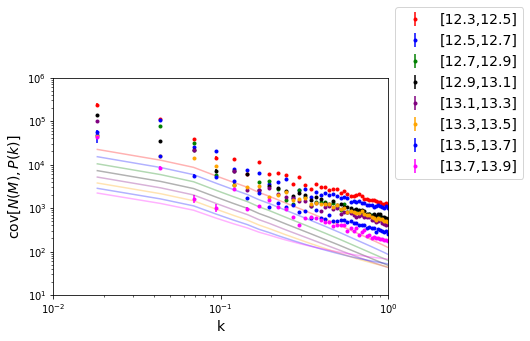

In [473]:
c=['r','b','g','k','purple','orange','blue','magenta']
for i in range(n_bins):
    plt.plot(comb_k,model_cov[i],c=c[i],alpha=0.3)
    plt.errorbar(comb_k,-comb_cov_Nm_Pk[i],yerr=jackknife_comb_cov_err[i],
                 label=r'[%.1f,%.1f]'%(np.log10(mass_low[i]),np.log10(mass_high[i])),
                 ls='',marker='.',c=c[i])
plt.legend();
plt.ylabel(r'$\mathrm{cov}\left[N(M),P(k)\right]$',fontsize=14)
plt.xlabel('k',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-2,1]);
plt.ylim([10,1e6]);
plt.gca().legend(bbox_to_anchor=(1.,0.5),fontsize=14);

In [474]:
model_cov = []
for i in range(n_bins):
    this_model = N_P_cov(mass_low[i],mass_high[i],comb_k)
    this_model.load_power_model([8.4123486,1.60506271],'EFT',1,1,1)
    model_cov.append(this_model.compute_covariance(1,0,0,0))

#### no HSV terms

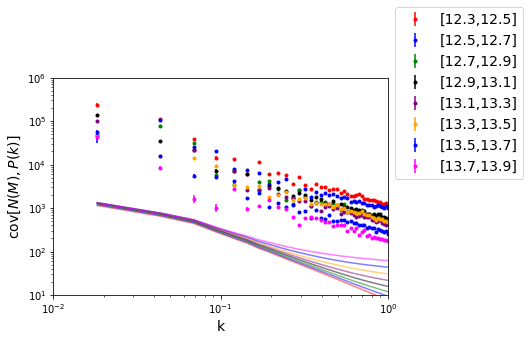

In [476]:
c=['r','b','g','k','purple','orange','blue','magenta']
for i in range(n_bins):
    plt.plot(comb_k,model_cov[i],c=c[i],alpha=0.5)
    plt.errorbar(comb_k,-comb_cov_Nm_Pk[i],yerr=jackknife_comb_cov_err[i],
                 label=r'[%.1f,%.1f]'%(np.log10(mass_low[i]),np.log10(mass_high[i])),
                 ls='',marker='.',c=c[i])
plt.legend();
plt.ylabel(r'$\mathrm{cov}\left[N(M),P(k)\right]$',fontsize=14)
plt.xlabel('k',fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-2,1]);
plt.ylim([10,1e6]);
plt.gca().legend(bbox_to_anchor=(1.,0.5),fontsize=14);

### NB: b2,b3 terms are wrong here. Should probably be convolutions.

(100, 100000.0)

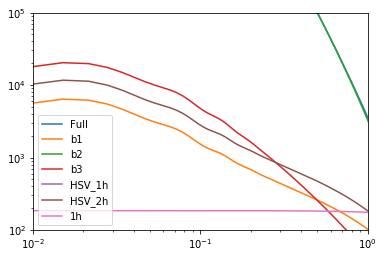

In [480]:
cov_model = N_P_cov(1e13,1e14,k)
cov_model.load_power_model([0.,1.],'EFT',1,1,1)
plt.plot(k,cov_model.compute_covariance(1,1,1),label='Full')
plt.plot(k,cov_model.compute_two_halo_b1(1),label='b1')
plt.plot(k,cov_model.compute_two_halo_b2(1),label='b2')
plt.plot(k,cov_model.compute_two_halo_b3(1),label='b3')
plt.plot(k,cov_model.compute_HSV_term_1h(1),label='HSV_1h')
plt.plot(k,cov_model.compute_HSV_term_2h(1),label='HSV_2h')
plt.plot(k,cov_model.compute_one_halo(),label='1h')
plt.yscale('log')
plt.legend();
plt.xscale('log')
plt.xlim([1e-2,1])
plt.ylim([100,1e5])